In [1]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import random
from torch.utils.data.dataset import TensorDataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
from torch.optim import Adam
from pytorch_lightning import Trainer
import os
import numpy as np
import pandas as pd
from os.path import join
from typing import Optional
from config import processed_data_path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm
from optuna.integration import PyTorchLightningPruningCallback
from scipy.stats import wasserstein_distance 
import joblib
import optuna
%matplotlib inline
from matplotlib import pyplot as plt
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import r2_score
from scipy.stats import wasserstein_distance
import threading
import concurrent
from sklearn.metrics import r2_score

/mnt/D/estagio_lip_2/env_estagio_lip_2/lib/python3.8/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


In [2]:
import glob
from config import *
bkg_files = glob.glob(join(raw_data_path, "bkg.*"))
signal_files = list(set(glob.glob(join(raw_data_path, "*.*"))) - set(bkg_files))
all_files = bkg_files + signal_files

print("Signal files:", len(signal_files), "\nBackground files:", len(bkg_files), "\n> Total:", len(all_files))

Signal files: 7 
Background files: 1 
> Total: 8


In [19]:
from os.path import basename
all_data = []

for path in all_files:
    data = pd.read_hdf(path, index_col=0)

    data['name'] = basename(path).replace(".h5", "")
    all_data.append(data)

data = pd.concat(all_data)
del all_data
data = data[['name', 'ScalarHT_HT', 'gen_xsec']]

In [ ]:
# Normalizing the data
data['ScalarHT_HT'] = data['ScalarHT_HT'] - min(data['ScalarHT_HT'])
max_value = max(data['ScalarHT_HT'])
data['ScalarHT_HT'] = data['ScalarHT_HT'] / max_value

In [20]:
bkg = data[data['name'] == 'bkg']
signal = data[data['name'] != 'bkg']

ROC SCORE for wohg_hq1000: 0.9832931622154065
ROC SCORE for hg3000_hq1200: 0.992167161375106
ROC SCORE for hg3000_hq1000: 0.9889815213200738
ROC SCORE for hg3000_hq1400: 0.9936489060778734
ROC SCORE for wohg_hq1200: 0.9912160216173462
ROC SCORE for fcnc: 0.7169437467115497
ROC SCORE for wohg_hq1400: 0.9946774290488564


<ipython-input-22-cf21420da490>:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_roc.show()


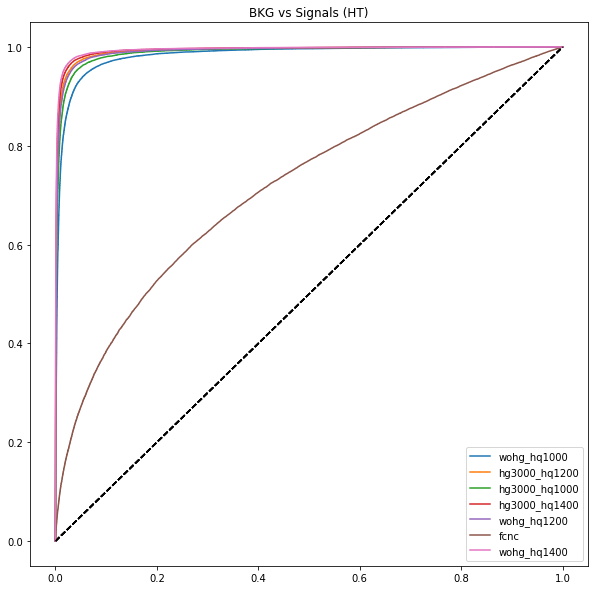

In [22]:
fig_roc, ax_roc = plt.subplots(figsize=(10,10))
from sklearn.metrics import roc_auc_score, roc_curve
for x in signal['name'].unique():

    current_signal = signal[signal['name'] == x]['ScalarHT_HT']
    current_bkg = bkg['ScalarHT_HT']


    # Labels
    bkg_labels = np.zeros(current_bkg.shape[0]).astype(int)
    signal_labels = np.ones(current_signal.shape[0]).astype(int)
    labels = np.concatenate([bkg_labels, signal_labels])

    # Score
    score = pd.concat([bkg['ScalarHT_HT'], signal[signal['name'] == x]['ScalarHT_HT']])

    # Weights
    weights = pd.concat([
                        bkg['gen_xsec'], 
                        signal[signal['name'] == x]['gen_xsec']
                        ])


    fpr, tpr, thr = roc_curve(
                    y_true=labels, 
                    y_score=score,
                    sample_weight=weights,
                    )
            
            
    ax_roc.plot(fpr, tpr, label=x.replace('.h5', ''))
    ax_roc.plot([0,1],[0,1], 'k--')

    print(f"ROC SCORE for {x.replace('.h5', '')}:", 
            roc_auc_score(y_true=labels, 
            y_score=score,
            sample_weight=weights))

fig_roc.show()
ax_roc.set_title(f"BKG vs Signals (HT)")
ax_roc.legend()

# OLD CODE

In [ ]:
bkg = _dataset(category='test',variant='bkg').all_data()
signal = _dataset(category='all',variant='signal').all_data()

In [ ]:
# Normalizing the data
signal['ScalarHT_HT'] = signal['ScalarHT_HT'] - min(signal['ScalarHT_HT'])
bkg['ScalarHT_HT'] = bkg['ScalarHT_HT'] - min(bkg['ScalarHT_HT'])
max_value = max(max(signal['ScalarHT_HT']), max(bkg['ScalarHT_HT']))
bkg['ScalarHT_HT'] = bkg['ScalarHT_HT'] / max_value
signal['ScalarHT_HT'] = signal['ScalarHT_HT'] / max_value

In [ ]:
fig_roc, ax_roc = plt.subplots(figsize=(10,10))
from sklearn.metrics import roc_auc_score, roc_curve
for x in signal['name'].unique():

    current_signal = signal[signal['name'] == x]['ScalarHT_HT']
    current_bkg = bkg['ScalarHT_HT']


    # Labels
    bkg_labels = np.zeros(current_bkg.shape[0]).astype(int)
    signal_labels = np.ones(current_signal.shape[0]).astype(int)
    labels = np.concatenate([bkg_labels, signal_labels])

    # Score
    score = pd.concat([bkg['ScalarHT_HT'], signal[signal['name'] == x]['ScalarHT_HT']])

    # Weights
    weights = pd.concat([
                        bkg['weights'], 
                        signal[signal['name'] == x]['weights']
                        ])


    fpr, tpr, thr = roc_curve(
                    y_true=labels, 
                    y_score=score,
                    sample_weight=weights,
                    )
            
            
    ax_roc.plot(fpr, tpr, label=x.replace('.h5', ''))
    ax_roc.plot([0,1],[0,1], 'k--')

    print(f"ROC SCORE for {x.replace('.h5', '')}:", 
            roc_auc_score(y_true=labels, 
            y_score=score,
            sample_weight=weights))

fig_roc.show()
ax_roc.set_title(f"BKG vs Signals (HT)")
ax_roc.legend()